Import libraries

In [185]:
import json
import string
import morfeusz2
import numpy as np
import pandas as pd
import itertools as it
import operator as op
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [186]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zabso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Korpus dokumentów

In [187]:
corpus_dir = "./teksty"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files_names = corpus.fileids()
files_names

['businessinsider_artykul_AI.txt',
 'cefarm_artykul_medycyna.txt',
 'computerworld_artykul_AI.txt',
 'domnin_artykul_medycyna.txt',
 'filozofuj_artykul_gaming.txt',
 'fortnite_opis_gaming.txt',
 'gazetaprawna_artykul_prawo.txt',
 'gryonline_recenzja_gaming.txt',
 'lex_komentarz_prawo.txt',
 'lex_pismo_prawo.txt',
 'lukasiewicz_artykul_AI.txt',
 'mezopotamia_praca_medycyna.txt',
 'mfiles_statut_prawo.txt',
 'rutinoscorbin_ulotka_medycyna.txt',
 'swps_artykul_gaming.txt',
 'uj_praca_medycyna.txt',
 'uj_sylabus_prawo.txt',
 'unite_artykul_AI.txt',
 'uł_praca_gaming.txt',
 'wikipedia_chatgpt_AI.txt']

Wstępne przygotowanie dokumentów

In [188]:
documents = {}
for file in files_names:
    documents[file] = corpus.raw(file)
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "businessinsider_artykul_AI.txt": "Kevin Kelly: AI stworzy najpotężniejsze problemy — i to dobrze [WYWIAD]\r\n\r\nKevin Kelly jest współzałożycielem nagradzanego magazynu WIRED, założycielem popularnej witryny Cool Tools, która od 20 lat codziennie recenzuje narzędzia, autorem wielu bestsellerów o przyszłości technologii i doskonałym ekspertem — jeśli ktoś lubi świat technologii, pewnie nieraz zetknął się z jego nazwiskiem. W rozmowie z Business Insiderem dzieli się, jak zawsze, swoim optymizmem, ale też oryginalnymi przemyśleniami na temat AI i fascynującym spojrzeniem na świat. Kevin Kelly wystąpi też na konferencji Masters&Robots, która odbędzie się 22-23 października w Warszawie.\r\n\r\n    AI umożliwia robienie tego, co chcemy, ale jednocześnie zwiększa naszą pracę, ponieważ zmienia jej charakter, zamiast ją ograniczać\r\n    AI i ludzka kreatywność wzajemnie się uzupełniają, umożliwiając tworzenie rzeczy, których ani ludzie, ani AI nie mogliby stworzyć samodzielnie\r\n    C

In [189]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 'oraz',
 '

In [190]:
morf = morfeusz2.Morfeusz()
morf.analyse("Ala ma kota")

[(0, 1, ('Ala', 'Ala', 'subst:sg:nom:f', ['imię'], [])),
 (0, 1, ('Ala', 'Al', 'subst:sg:gen.acc:m1', ['imię'], [])),
 (0, 1, ('Ala', 'Alo', 'subst:sg:gen.acc:m1', ['imię'], [])),
 (1, 2, ('ma', 'mój:A', 'adj:sg:nom.voc:f:pos', [], [])),
 (1, 2, ('ma', 'mieć', 'fin:sg:ter:imperf', [], [])),
 (2, 3, ('kota', 'kota', 'subst:sg:nom:f', ['nazwa_pospolita'], [])),
 (2,
  3,
  ('kota',
   'kot:Sm1',
   'subst:sg:gen.acc:m1',
   ['nazwa_pospolita'],
   ['pot.,środ.'])),
 (2, 3, ('kota', 'kot:Sm2', 'subst:sg:gen.acc:m2', ['nazwa_pospolita'], []))]

In [191]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group): 
        pairs = ((len(descr), lemma) for _, _, (_, lemma, descr, _, _, ) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

In [192]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language='polish') if word not in stoplist])

In [193]:
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "businessinsider_artykul_AI.txt": "Kevin kelly AI stworzyć potężny problem dobrze wywiad Kevin kelly współzałożyciel nagradzać magazyn wired założyciel popularny witryna cool tools rok codziennie recenzować narzędzie autor wiele bestseller przyszłość technologia doskonały ekspert ktoś lubić świat technologia pewnie nieraz zetknąć nazwisko rozmowa business insiderem dzielić zawsze optymizm oryginalny przemyślenie temat AI fascynujący spojrzenie świat Kevin kelly wystąpić konferencja mastersrobots odbyć październik warszawa AI umożliwiać robić chcieć jednocześnie zwiększać nasz praca zmieniać charakter zamiast ograniczać AI ludzki kreatywność wzajemnie uzupełniać umożliwiać tworzenie rzecz lud AI móc stworzyć samodzielnie AI stwarzać potężny problem Kevin kelly wierzyć naszać zdolność rozwiązywać rośnie szybko Kevin kelly zdradzać my jaka zdanie obiecujący technologia przyszłość a jaki mieć porada młoda człowiek dopiero zaczynać kariera dużo informacja biznes znaleźć strona busines

Utworzenie macierzy częstości

In [194]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']
docs

,content
businessinsider_artykul_AI.txt,Kevin kelly AI stworzyć potężny problem dobrze...
cefarm_artykul_medycyna.txt,niech pierwszy rzucić kamień dziecko bać pokrz...
computerworld_artykul_AI.txt,chmura edge AI dobrze wykorzystać integracja p...
domnin_artykul_medycyna.txt,jaki rodzaj chirurgia czym zajmować chirurg ch...
filozofuj_artykul_gaming.txt,gra komputerowy stanowić poważny część współcz...
fortnite_opis_gaming.txt,czym fortnite poradnik początkująca twórca for...
gazetaprawna_artykul_prawo.txt,wyborca mieć prawo przedrzeć karta głosowanie ...
gryonline_recenzja_gaming.txt,recenzja assassin sekunda creed mirage zły czę...
lex_komentarz_prawo.txt,prawo szkolnictwo wysoki nauka komentarz autor...
lex_pismo_prawo.txt,pismo dzień luty r ministerstwo nauka szkolnic...


In [195]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [196]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01411433],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01297247, 0.01297247, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Chmury tagów

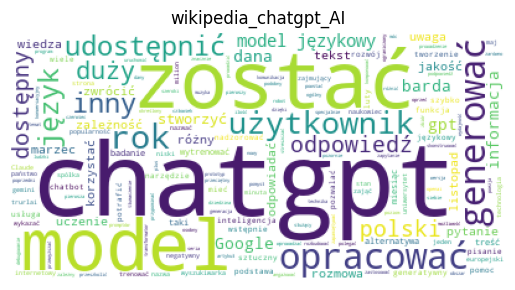

In [197]:
wordcloud = WordCloud(
    background_color="white",
    max_words=5000,
    contour_width=3,
    contour_color="orchid"
)
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(index.replace(".txt", ""))
    plt.savefig("./wordclouds/{}".format(index.replace(".txt", ".png")))

# Topic modelling

In [198]:
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./topics/{title}.png")

In [199]:
n_components = 4 
feature_names = count_vectorizer.get_feature_names_out()
n_top_features = 20
size = [1,4]

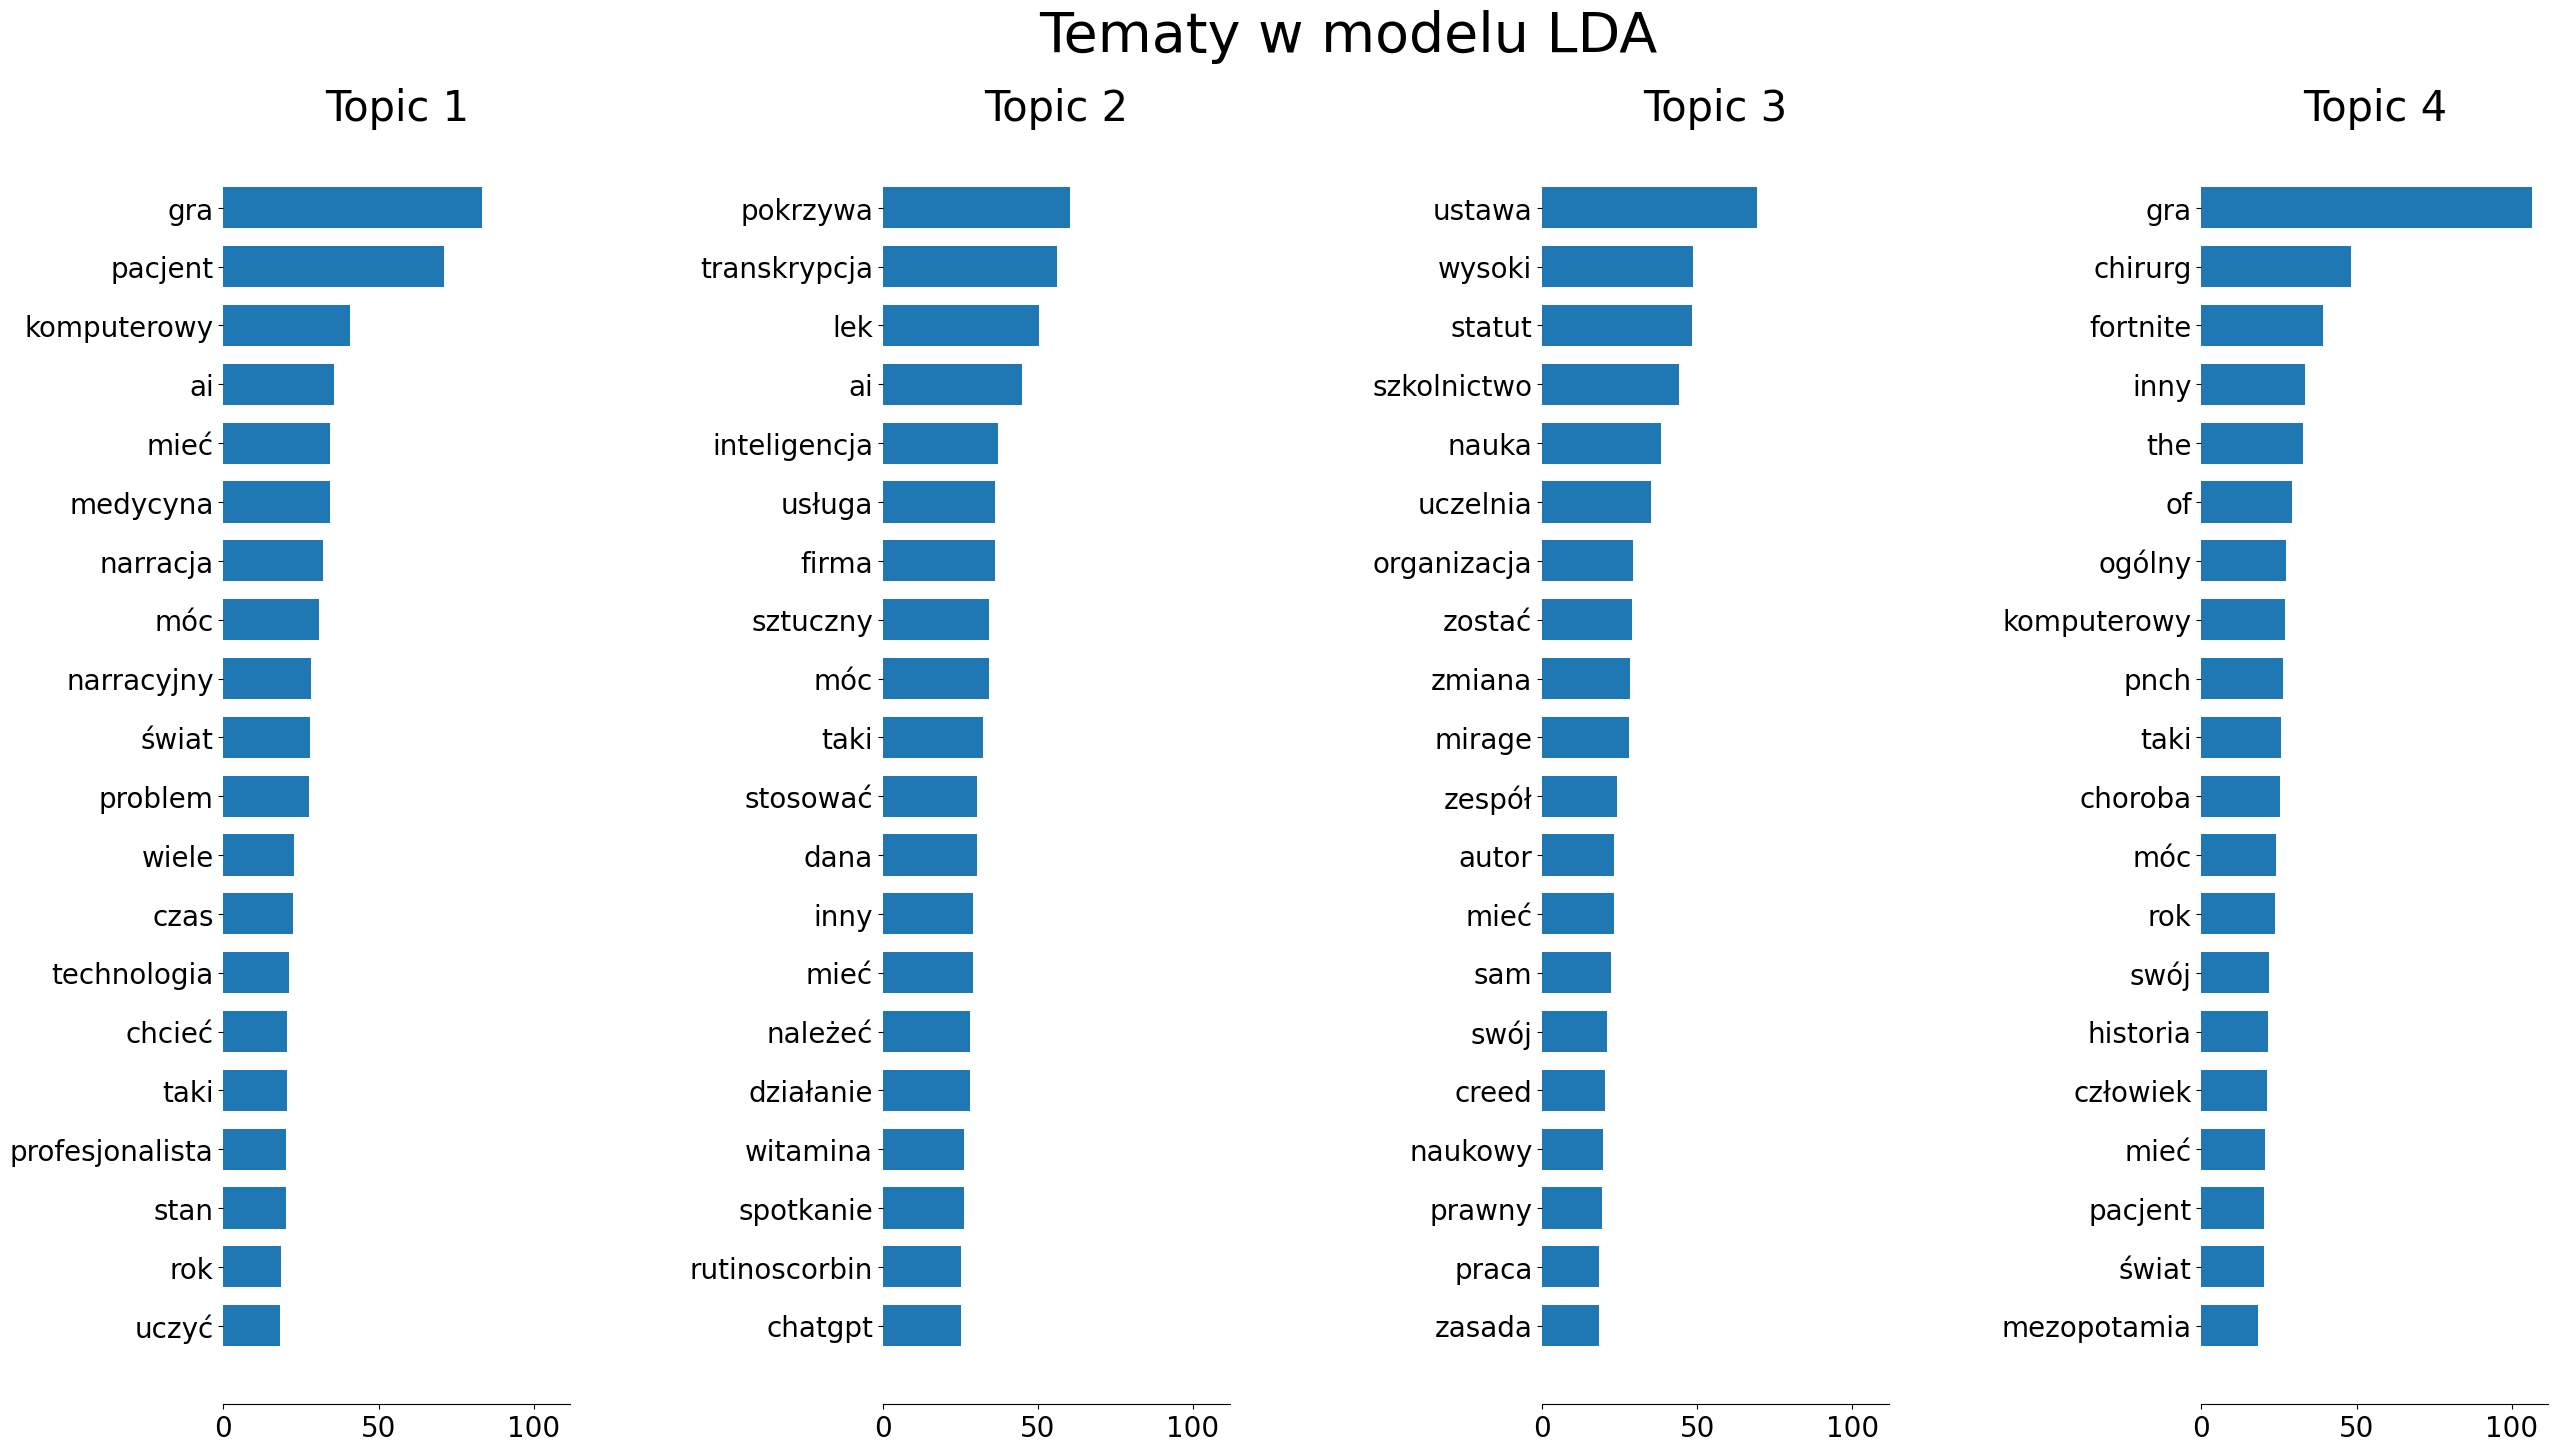

In [200]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='batch',
    learning_offset=50,
    random_state=0
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_features, "Tematy w modelu LDA", size)

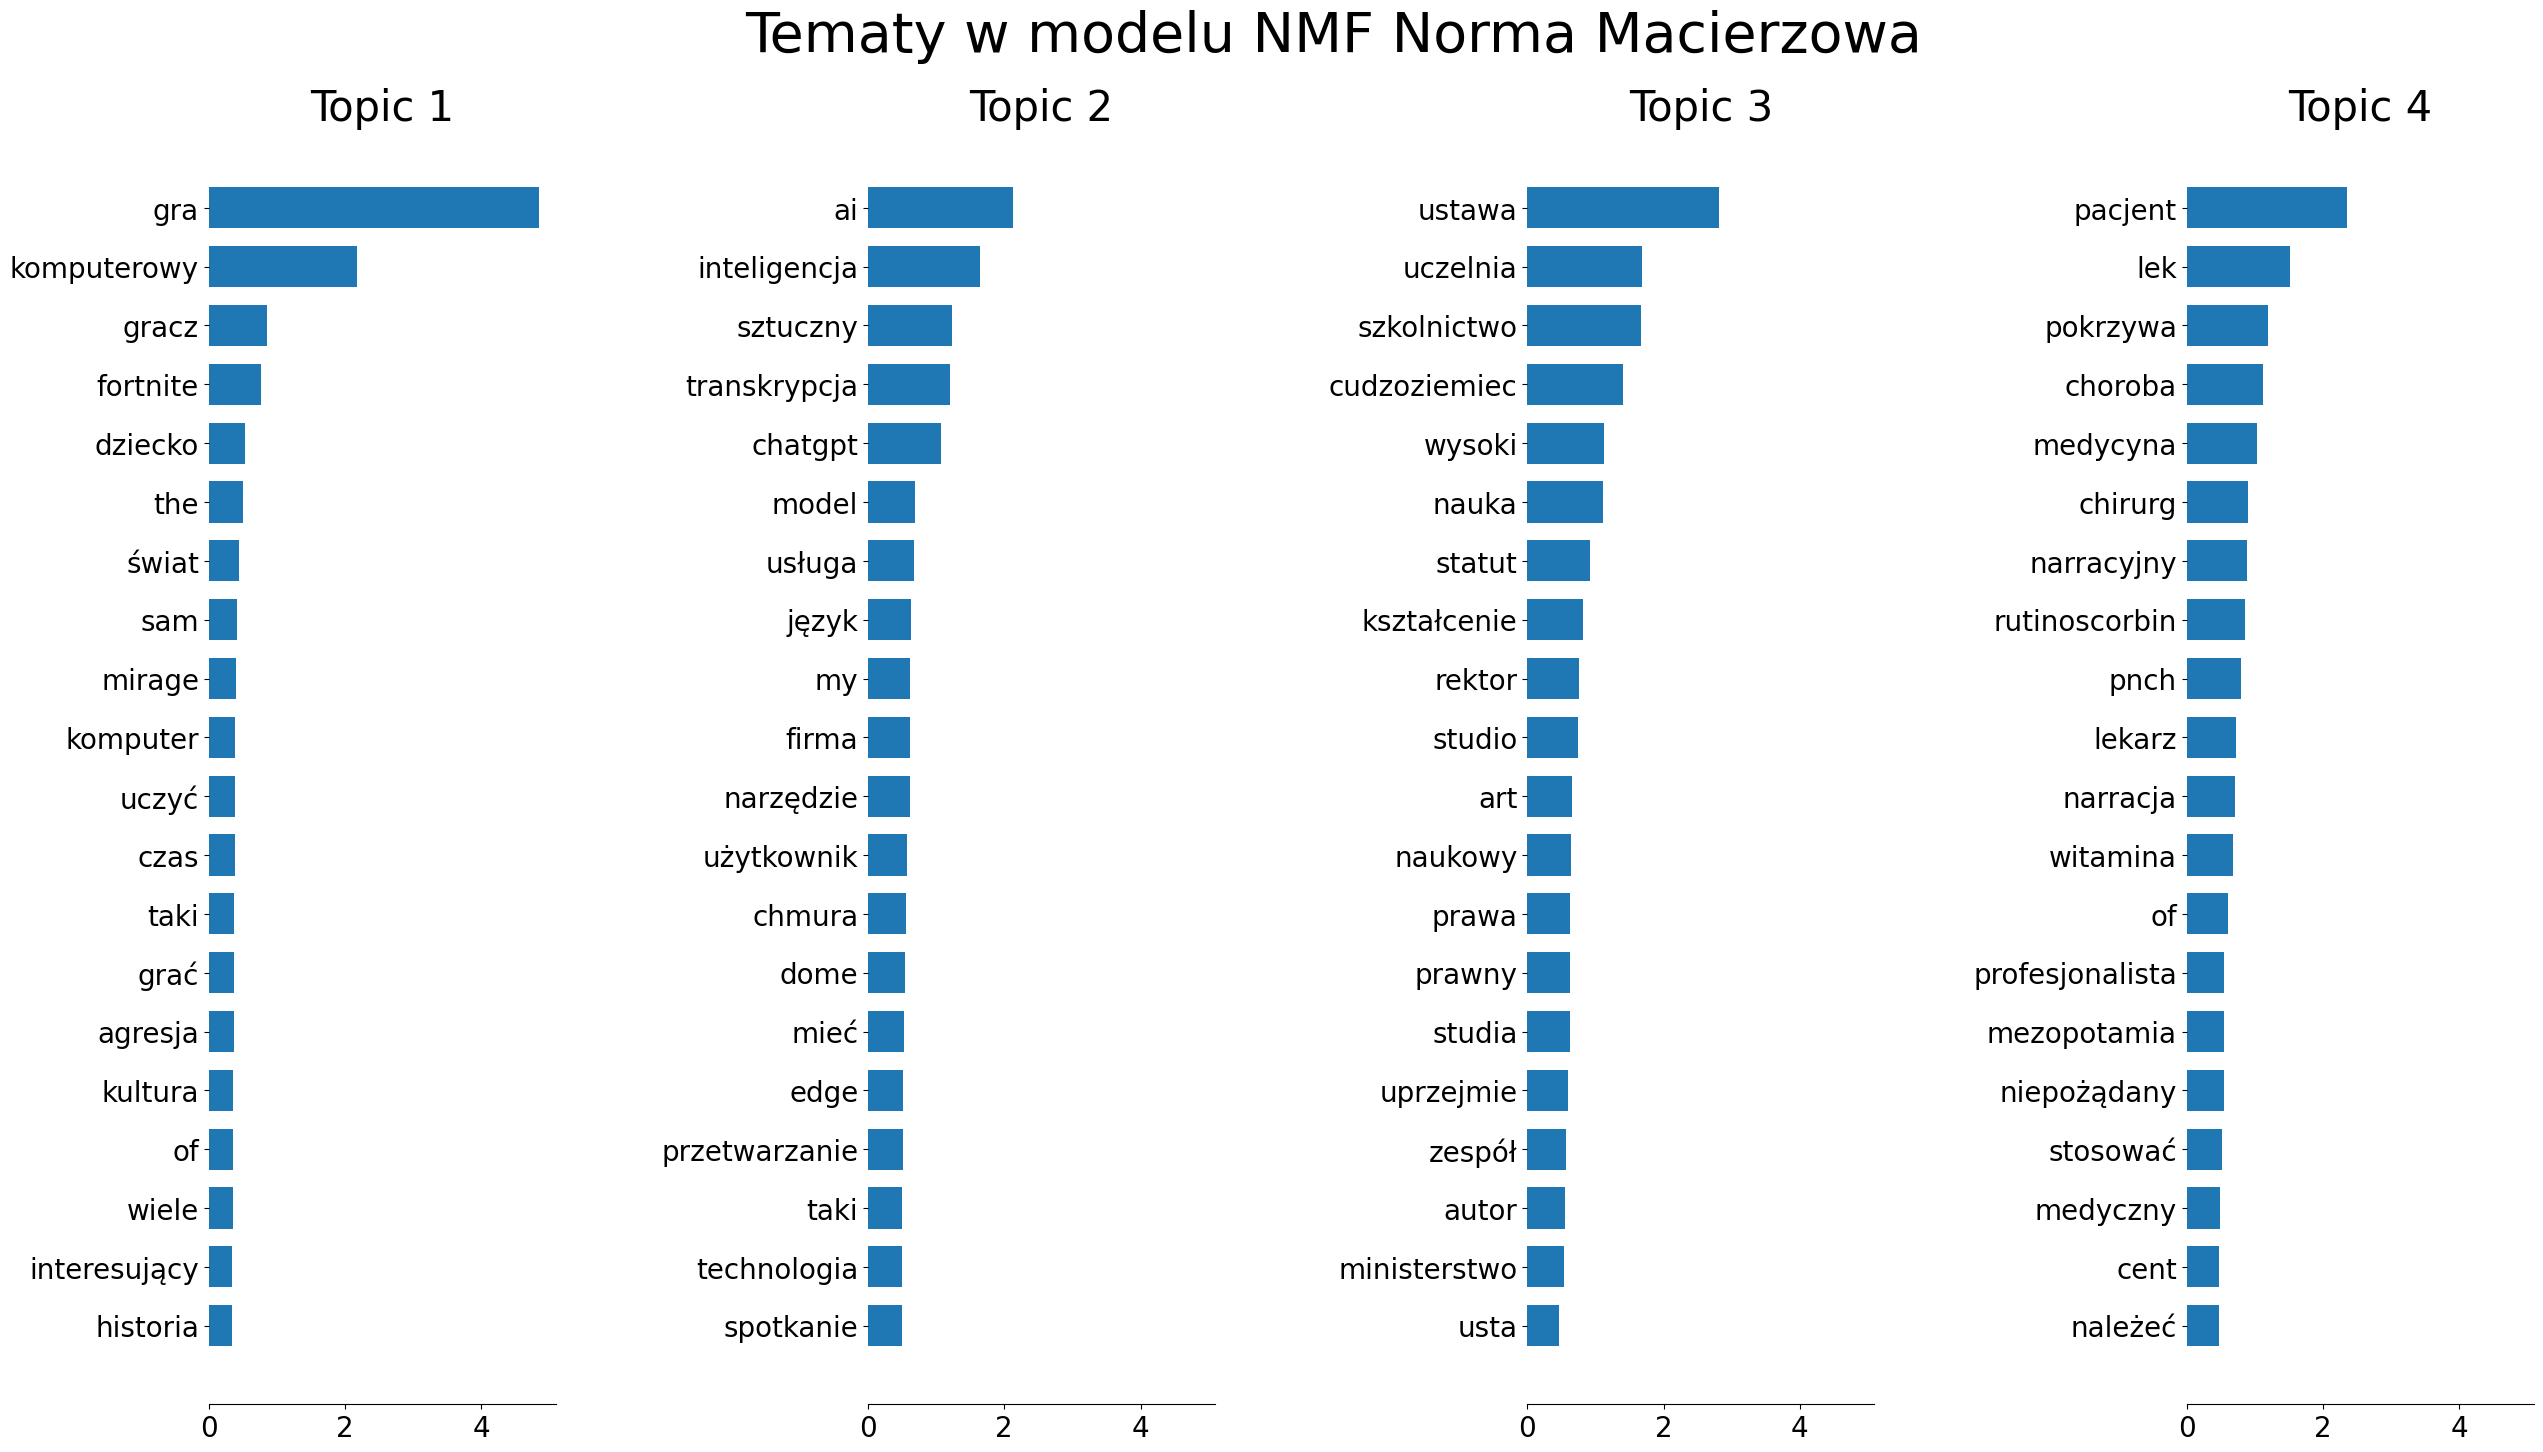

In [201]:
nmf_fm = NMF(
    n_components=n_components,
    random_state=1,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_fm.fit(counts_tfidf)
plot_top_words(nmf_fm, feature_names, n_top_features, "Tematy w modelu NMF Norma Macierzowa", size)

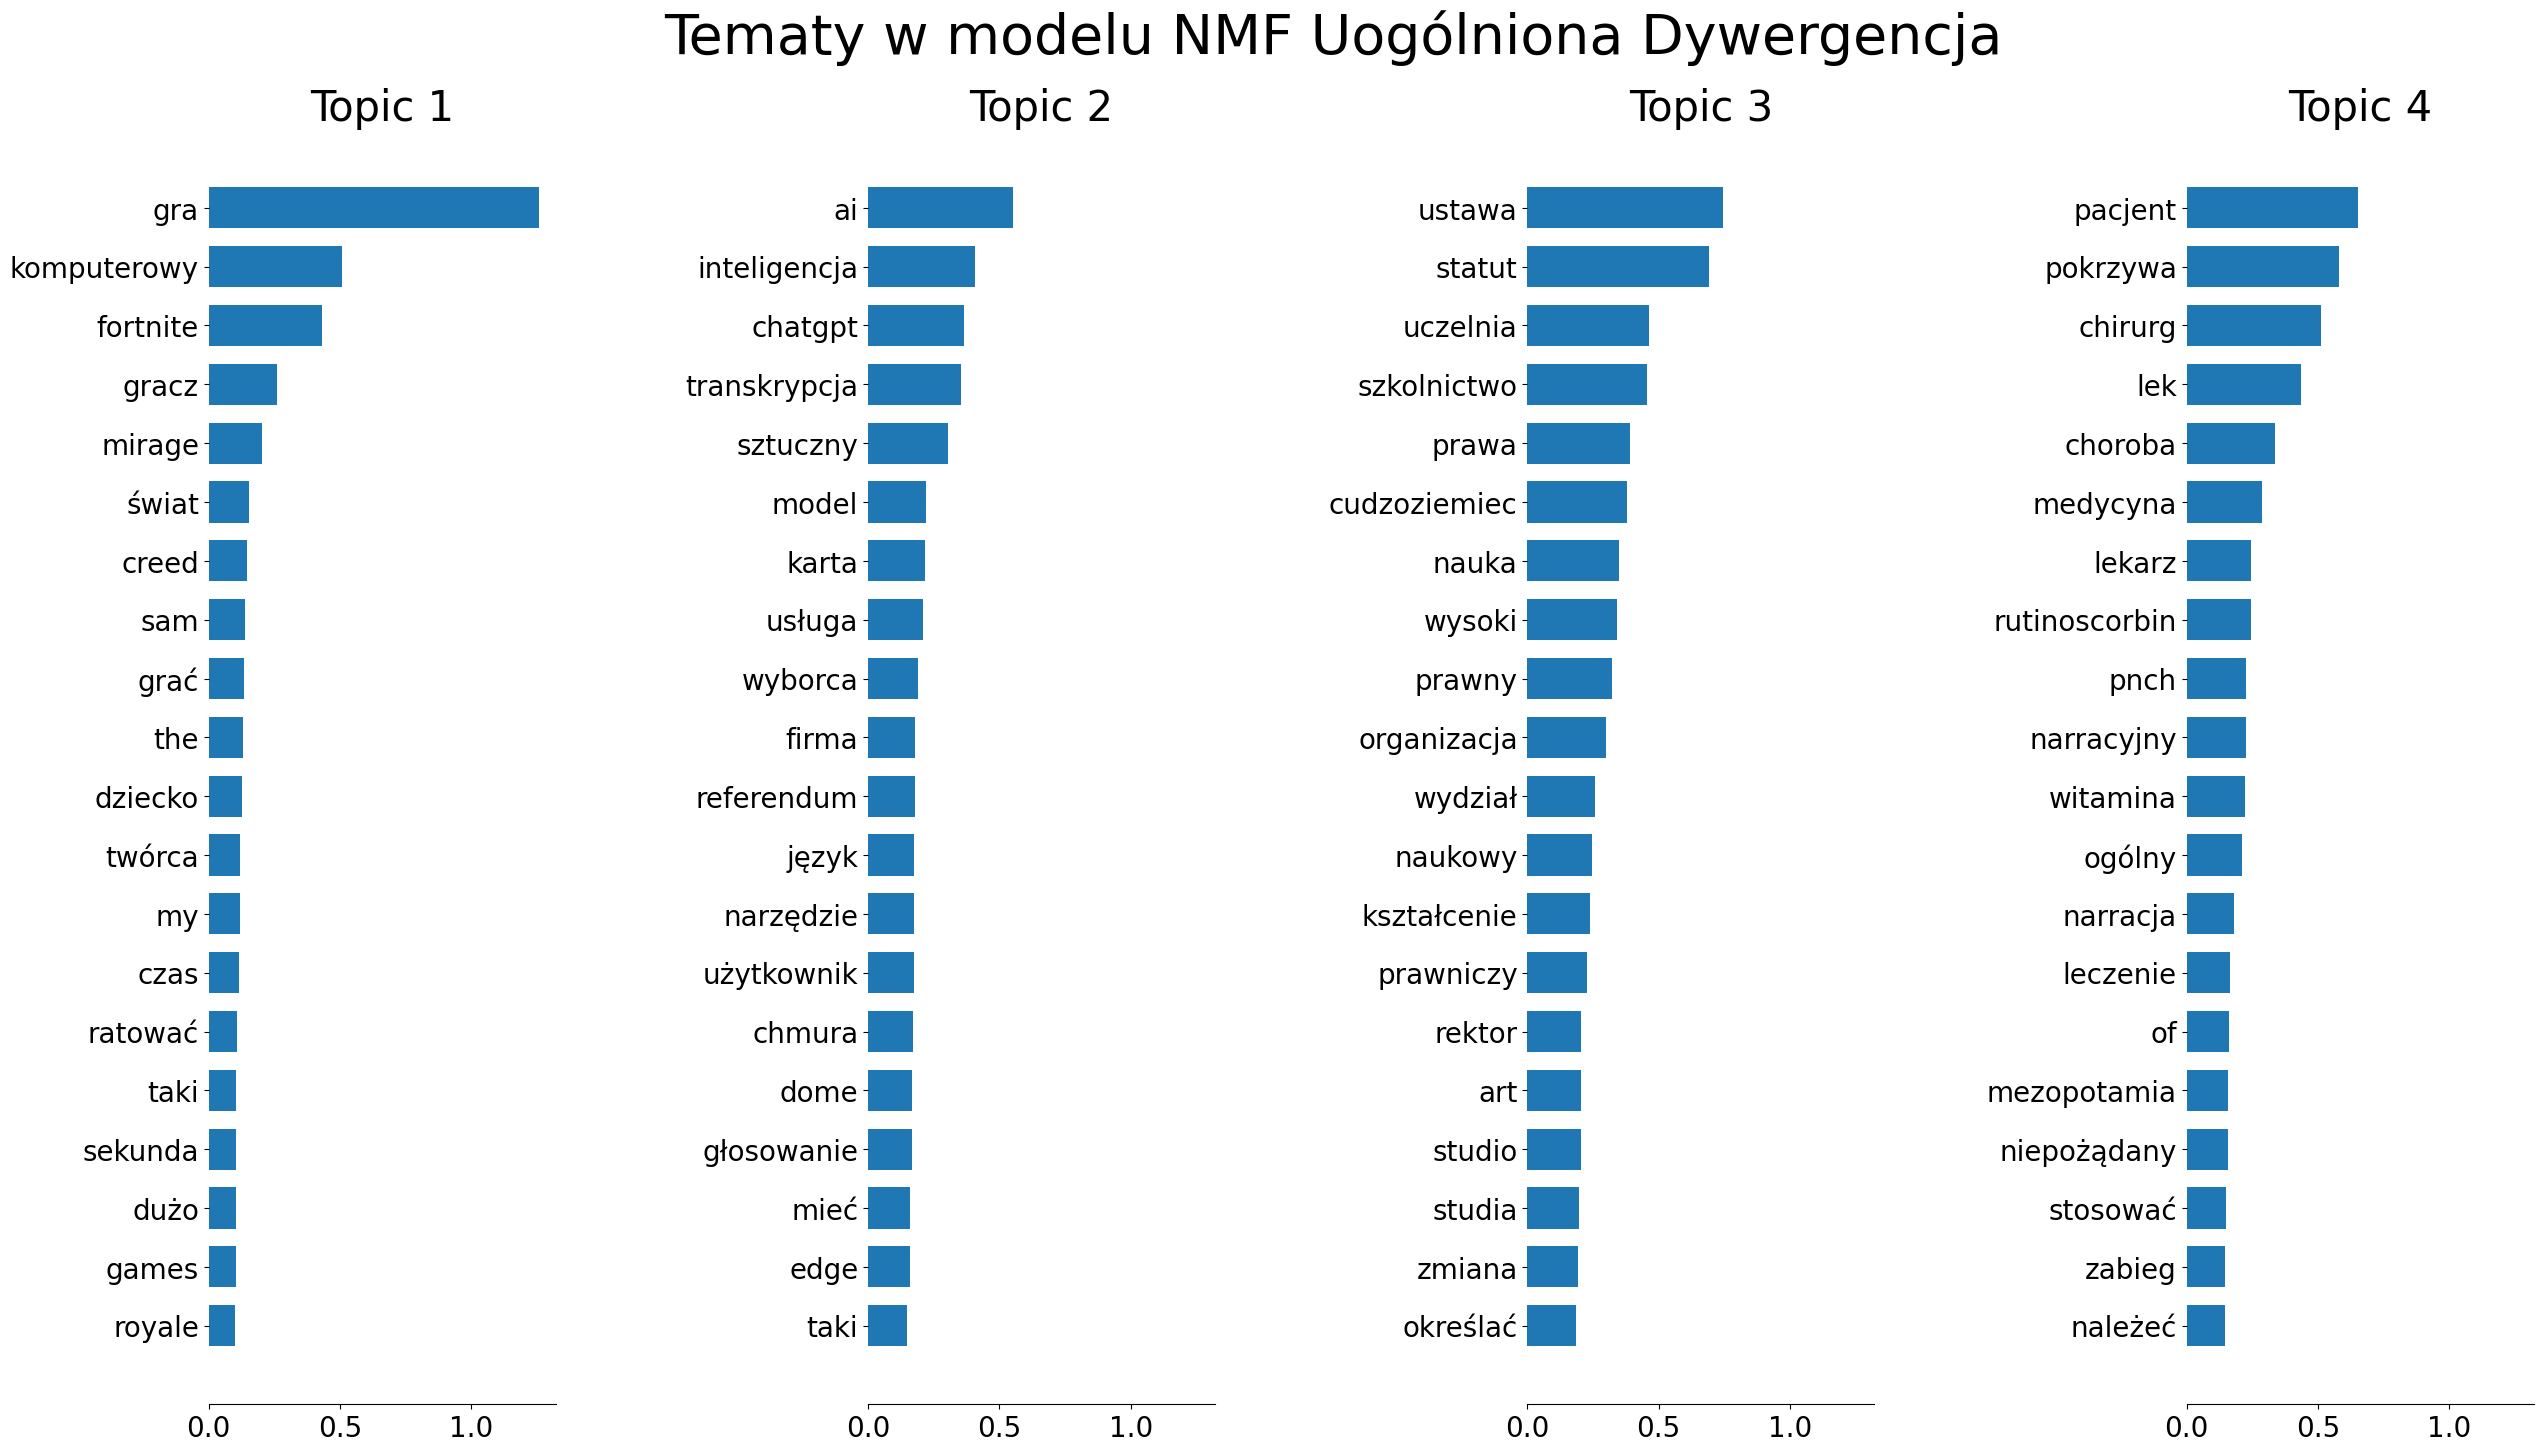

In [202]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_features, "Tematy w modelu NMF Uogólniona Dywergencja", size)

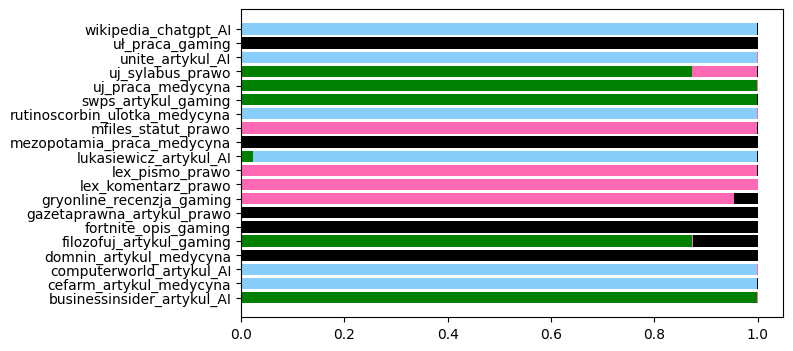

In [203]:
docs_topics = pd.DataFrame(lda.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'])
docs_topics.index = [file_name.replace('.txt', '') for file_name in files_names]
plt.figure(figsize=(7,4))
colors = ['green', 'lightskyblue', 'hotpink', 'black']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label = col, color = colors[i])
    left = [left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]
plt.show()

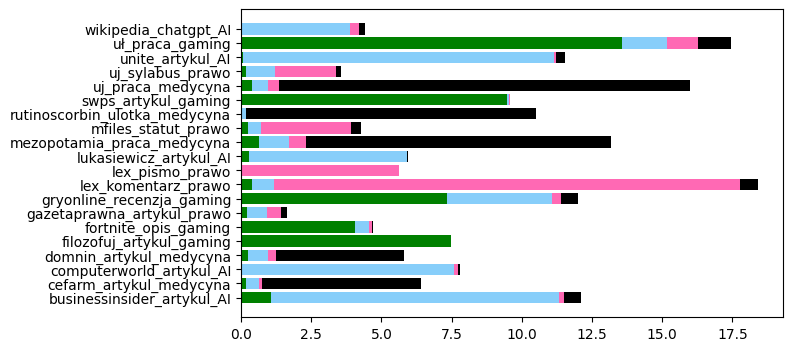

In [204]:
docs_topics = pd.DataFrame(nmf_fm.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'])
docs_topics.index = [file_name.replace('.txt', '') for file_name in files_names]
plt.figure(figsize=(7,4))
colors = ['green', 'lightskyblue', 'hotpink', 'black']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label = col, color = colors[i])
    left = [left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]
plt.show()

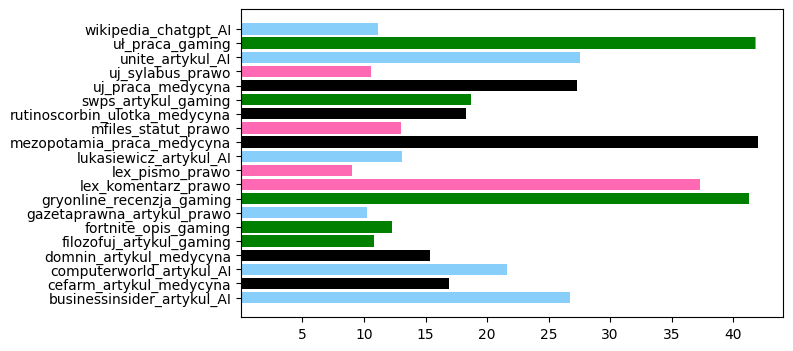

In [205]:
docs_topics = pd.DataFrame(nmf_kl.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'])
docs_topics.index = [file_name.replace('.txt', '') for file_name in files_names]
plt.figure(figsize=(7,4))
colors = ['green', 'lightskyblue', 'hotpink', 'black']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label = col, color = colors[i])
    left = [left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]
plt.show()

# Analiza skupień

In [206]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [207]:
cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(20,20)
cs

array([[1.        , 0.03561924, 0.15887612, 0.05112555, 0.09437489,
        0.05812374, 0.05372753, 0.17857405, 0.07638336, 0.03511828,
        0.30780394, 0.08632466, 0.03558914, 0.03208647, 0.10632837,
        0.05066189, 0.06705111, 0.18410511, 0.12304883, 0.12407085],
       [0.03561924, 1.        , 0.01546563, 0.04276745, 0.01589606,
        0.0100058 , 0.01426191, 0.03124387, 0.02180725, 0.0140594 ,
        0.02574942, 0.07076675, 0.01101982, 0.10927306, 0.03128585,
        0.04854136, 0.01413767, 0.01808888, 0.02301666, 0.01815353],
       [0.15887612, 0.01546563, 1.        , 0.02188464, 0.03444615,
        0.02819987, 0.01967251, 0.05537579, 0.05612075, 0.02334413,
        0.21200695, 0.0346566 , 0.0338751 , 0.01760507, 0.04490606,
        0.04118915, 0.08092275, 0.16656933, 0.07600412, 0.10621361],
       [0.05112555, 0.04276745, 0.02188464, 1.        , 0.02313794,
        0.01640471, 0.00683518, 0.03048186, 0.03627564, 0.01701022,
        0.03461214, 0.06800394, 0.01598696, 0

In [208]:
clustering = AgglomerativeClustering(
    n_clusters=3,
    metric="euclidean",
    linkage="ward",
    compute_distances=True
).fit(cs)
clustering.labels_

array([2, 0, 2, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 1, 2],
      dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

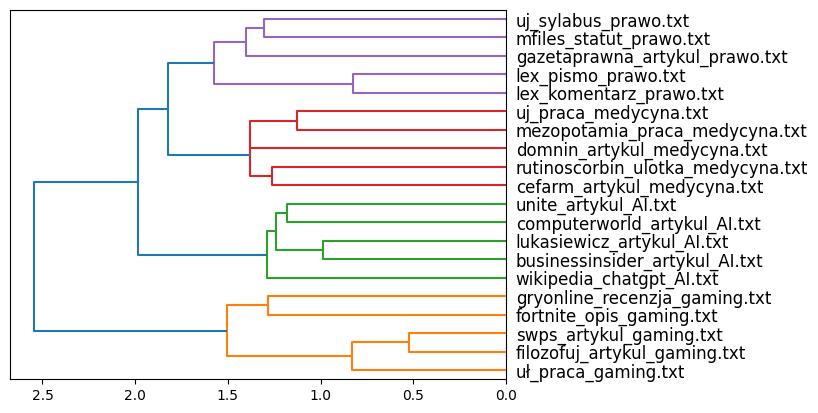

In [209]:
plot_dendrogram(
    clustering,
    labels = files_names,
    truncate_mode = 'level',
    orientation='left'
)
plt.show

In [210]:
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(20,20)
ed

array([[  0.        , 114.30223095, 104.30244484, 111.52129841,
        100.30453629, 103.2618032 ,  99.67447015, 116.        ,
        143.41548034,  98.38699101,  85.83122975, 121.09087497,
        109.        , 124.93198149, 106.315568  , 141.9154678 ,
         94.98420921, 121.1981848 , 130.49904214,  95.60857702],
       [114.30223095,   0.        , 104.47966309, 101.18300253,
         92.33634171,  96.0104161 ,  89.7329371 , 124.21352583,
        140.0392802 ,  86.1684397 ,  86.27861844, 112.57886125,
         99.19677414, 109.05503198, 100.7769815 , 133.38290745,
         83.48053665, 127.74192734, 132.947358  ,  87.47571091],
       [104.30244484, 104.47966309,   0.        , 100.96534059,
         88.9269363 ,  91.98912979,  87.56711712, 120.6855418 ,
        135.84918108,  83.38465087,  74.05403433, 114.76062042,
         95.84362264, 115.25189803,  98.        , 133.12024639,
         77.02596965, 110.85125168, 126.40806936,  79.586431  ],
       [111.52129841, 101.18300253, 1

In [211]:
clusering = AgglomerativeClustering(
    n_clusters=3,
    metric="precomputed",
    linkage="complete",
    compute_distances=True
).fit(ed)
clusering.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
      dtype=int64)

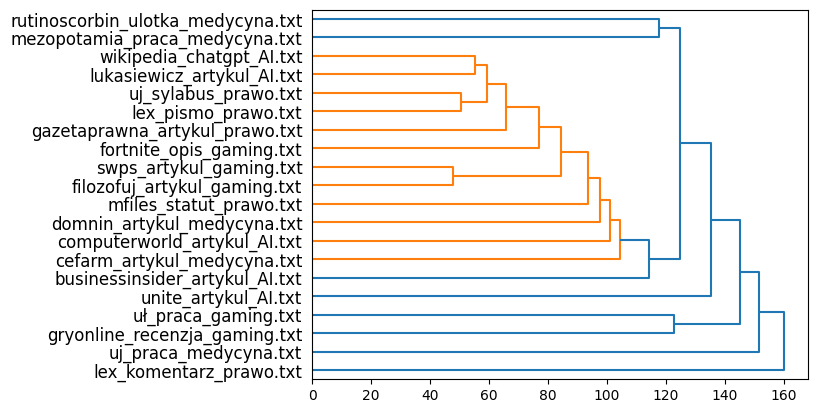

In [212]:
plot_dendrogram(
    clusering,
    labels = files_names,
    truncate_mode = 'level',
    orientation = 'right'
)
plt.show()

# N-gramy

In [213]:
documents_tokenized = {}
for key in documents:
    documents_tokenized[key] = word_tokenize(documents[key], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))  

{
    "businessinsider_artykul_AI.txt": [
        "Kevin",
        "kelly",
        "AI",
        "stworzyć",
        "potężny",
        "problem",
        "dobrze",
        "wywiad",
        "Kevin",
        "kelly",
        "współzałożyciel",
        "nagradzać",
        "magazyn",
        "wired",
        "założyciel",
        "popularny",
        "witryna",
        "cool",
        "tools",
        "rok",
        "codziennie",
        "recenzować",
        "narzędzie",
        "autor",
        "wiele",
        "bestseller",
        "przyszłość",
        "technologia",
        "doskonały",
        "ekspert",
        "ktoś",
        "lubić",
        "świat",
        "technologia",
        "pewnie",
        "nieraz",
        "zetknąć",
        "nazwisko",
        "rozmowa",
        "business",
        "insiderem",
        "dzielić",
        "zawsze",
        "optymizm",
        "oryginalny",
        "przemyślenie",
        "temat",
        "AI",
        "fascynujący",
        "spojrzen

businessinsider_artykul_AI.txt


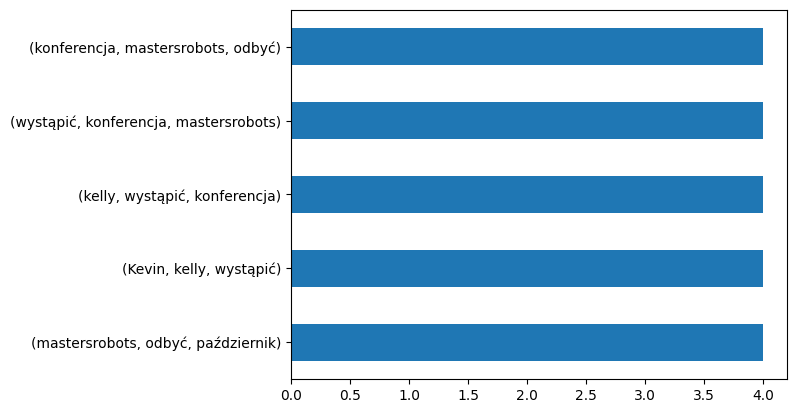

cefarm_artykul_medycyna.txt


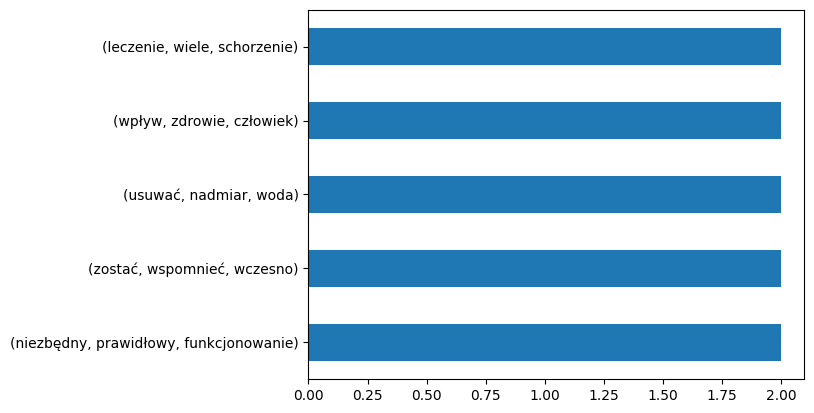

computerworld_artykul_AI.txt


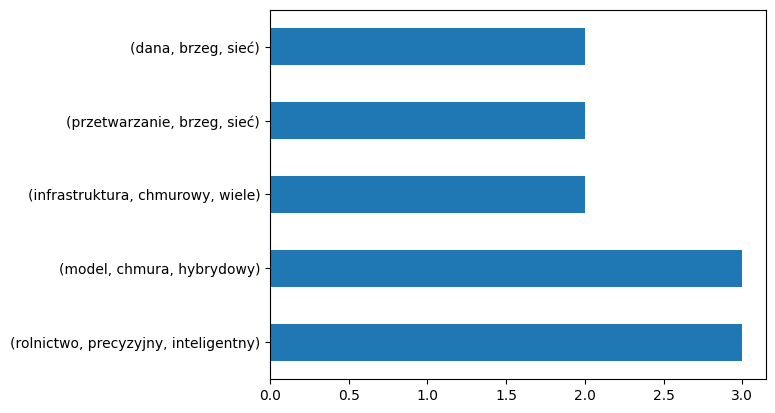

domnin_artykul_medycyna.txt


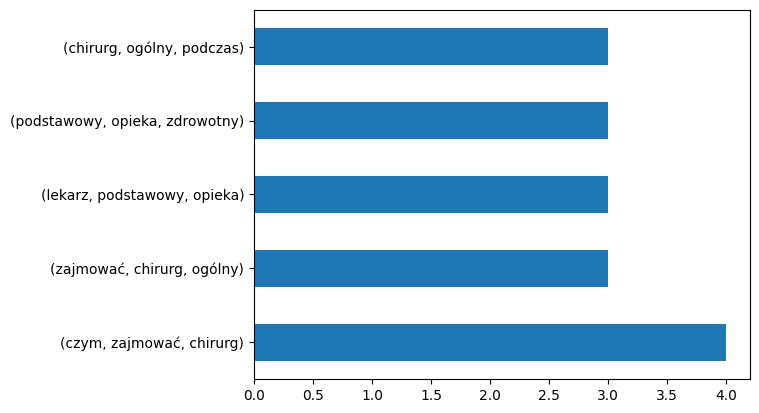

filozofuj_artykul_gaming.txt


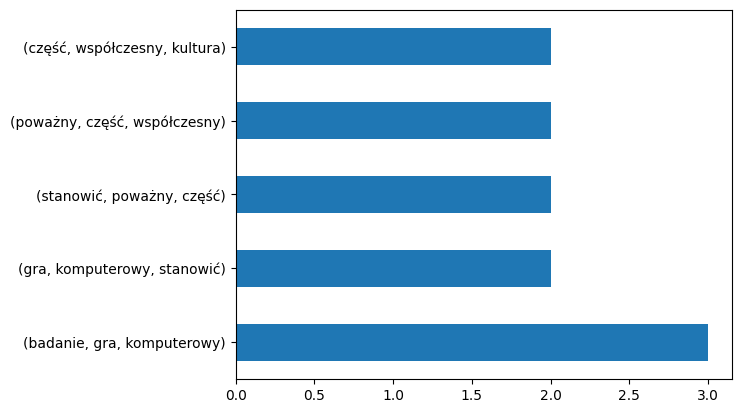

fortnite_opis_gaming.txt


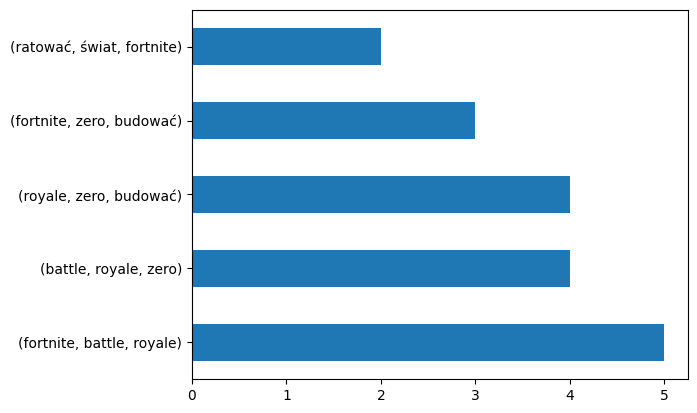

gazetaprawna_artykul_prawo.txt


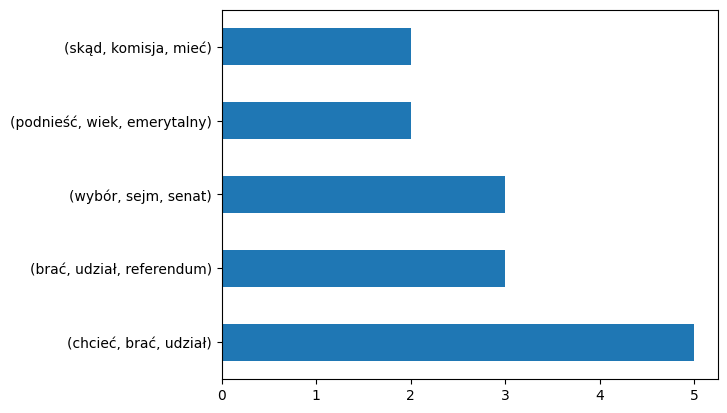

gryonline_recenzja_gaming.txt


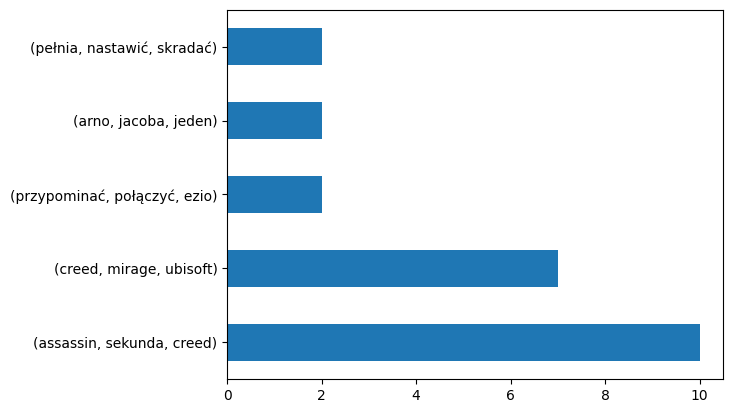

lex_komentarz_prawo.txt


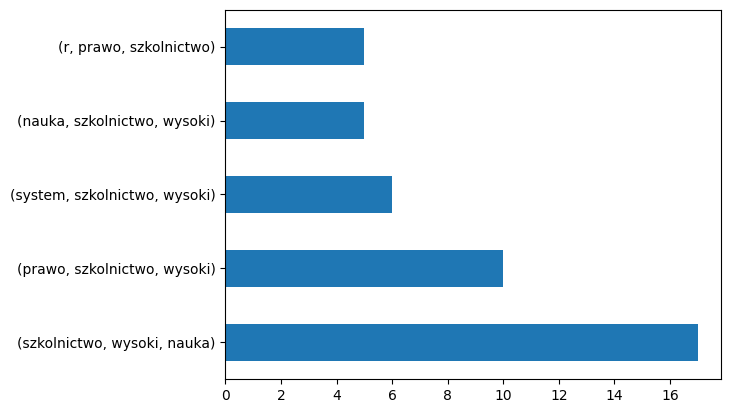

lex_pismo_prawo.txt


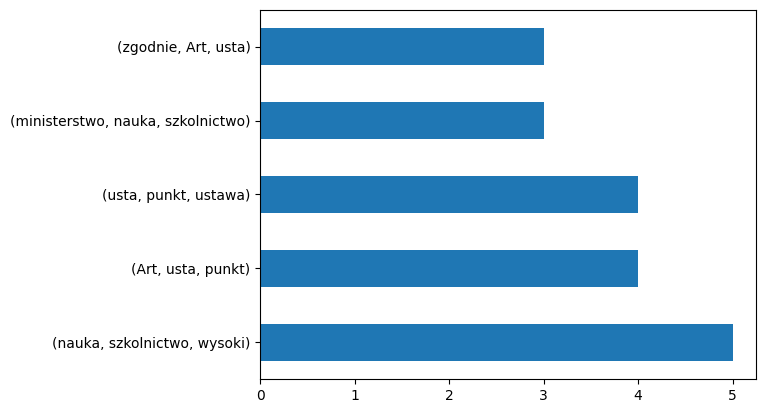

lukasiewicz_artykul_AI.txt


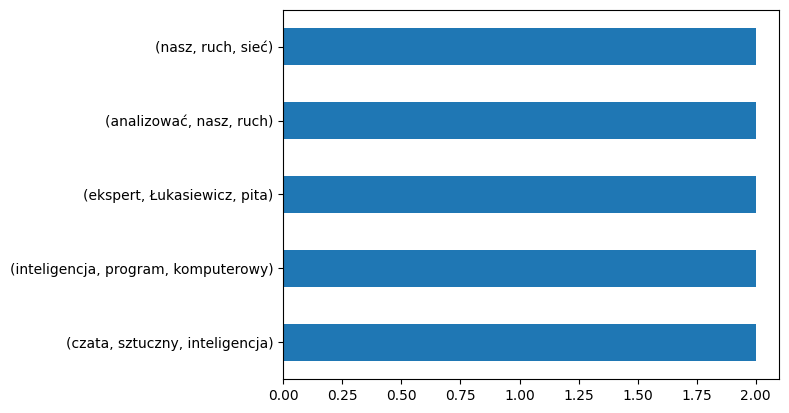

mezopotamia_praca_medycyna.txt


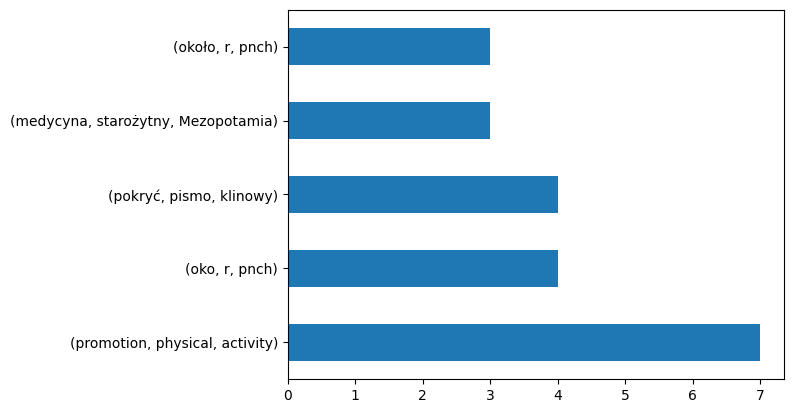

mfiles_statut_prawo.txt


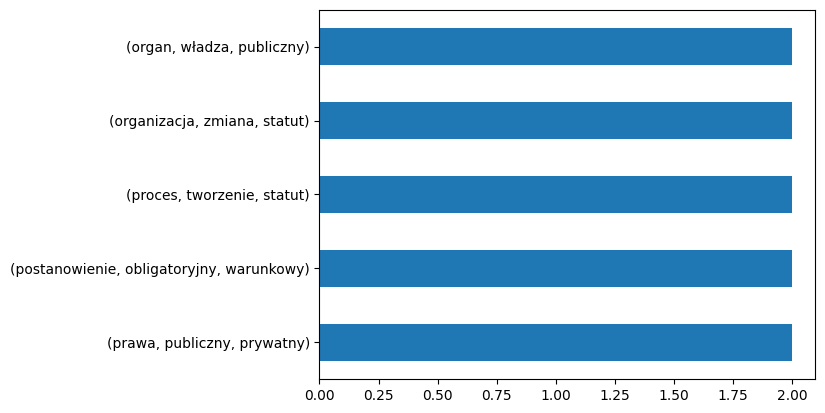

rutinoscorbin_ulotka_medycyna.txt


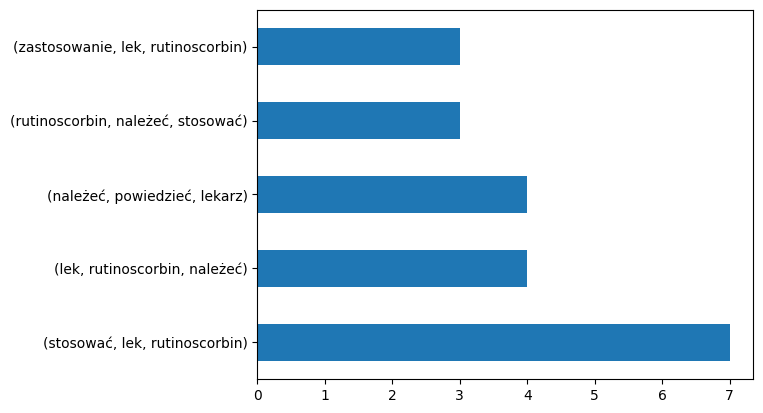

swps_artykul_gaming.txt


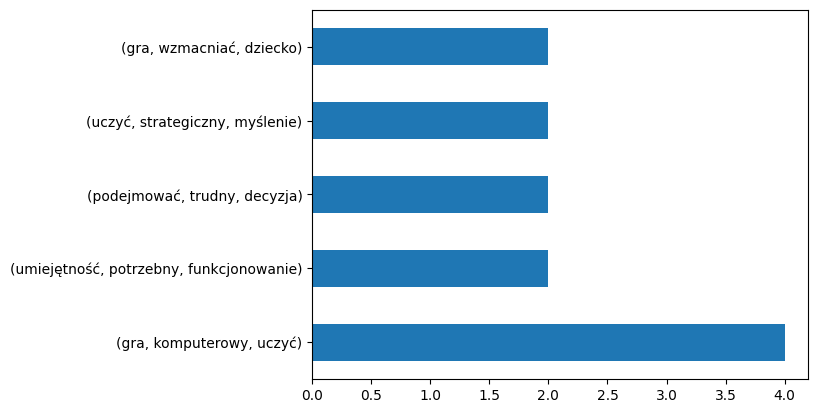

uj_praca_medycyna.txt


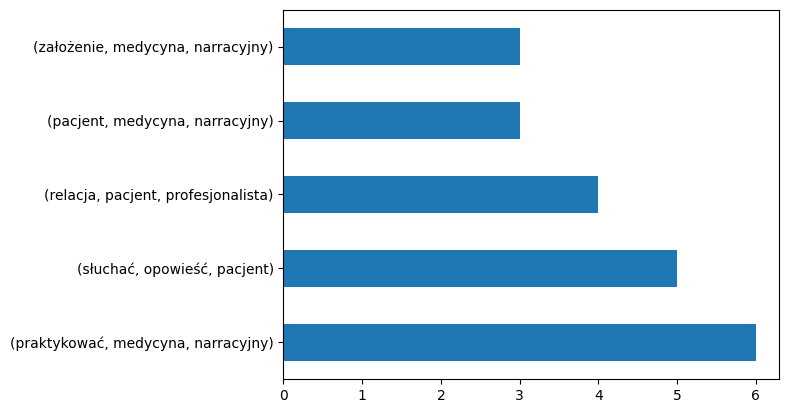

uj_sylabus_prawo.txt


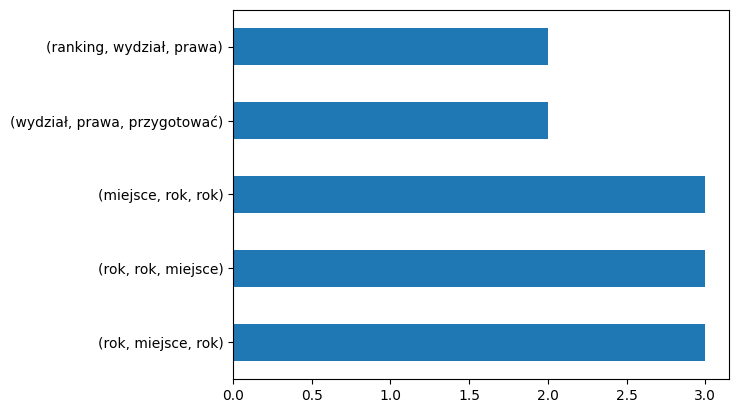

unite_artykul_AI.txt


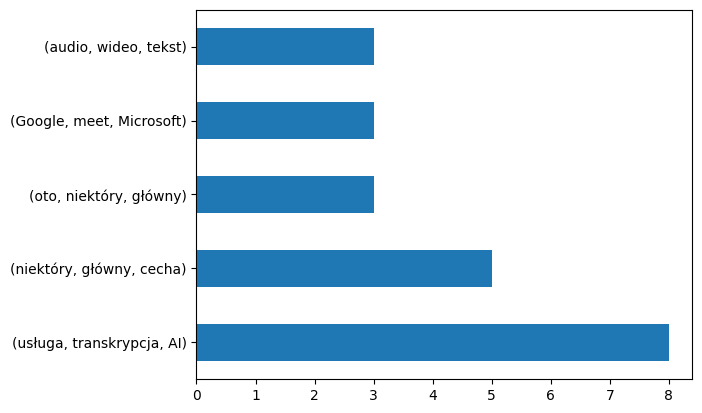

uł_praca_gaming.txt


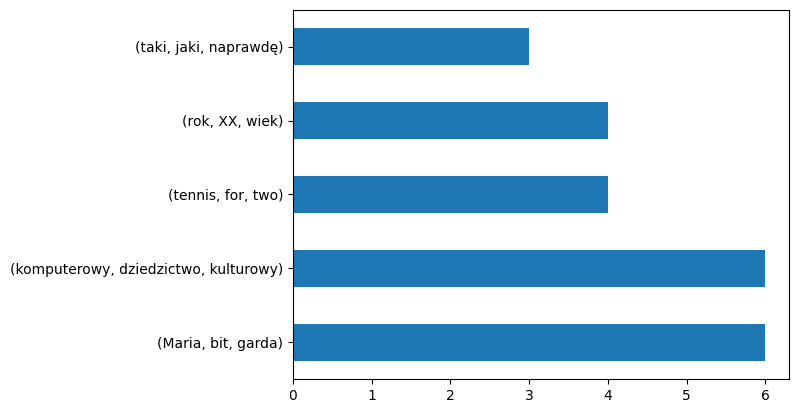

wikipedia_chatgpt_AI.txt


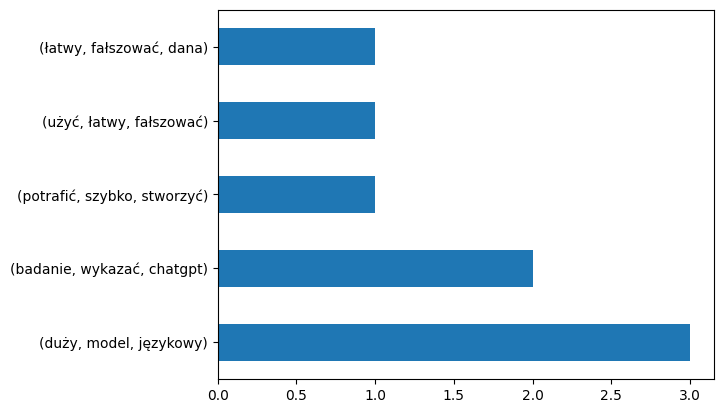

In [214]:
for title in documents_tokenized:
    n_gram = pd.Series(ngrams(documents_tokenized[title], 3)).value_counts()
    print(title)
    n_gram[:5].plot.barh()
    plt.show()

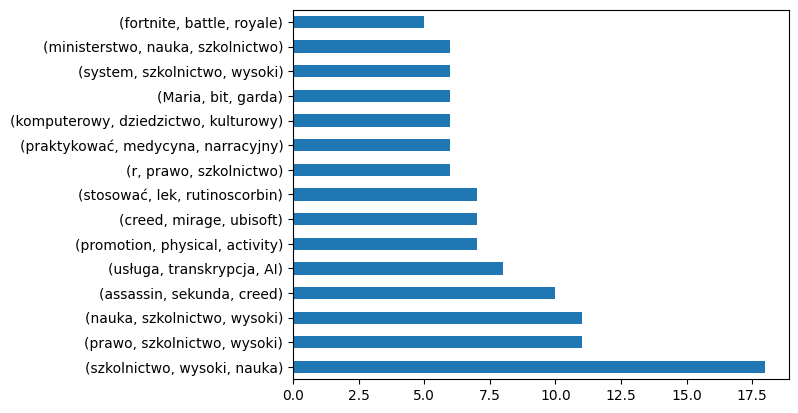

In [215]:
texts = ' '.join(docs['content']).split(" ")
n_gram = pd.Series(ngrams(texts, 3)).value_counts()
n_gram[:15].plot.barh()
plt.show()